In [99]:
import gymnasium as gym
import grid2op
from grid2op import gym_compat
from grid2op.Parameters import Parameters
from grid2op.Action import PlayableAction
from grid2op.Observation import CompleteObservation
from grid2op.Reward import L2RPNReward, N1Reward, CombinedScaledReward

from lightsim2grid import LightSimBackend
import numpy as np
from gymnasium.spaces import Box, Discrete

import matplotlib.pyplot as plt
from stable_baselines3 import DQN

import torch
import torch as th
import torch.nn as nn
from stable_baselines3.dqn.policies import DQNPolicy
import random

In [100]:
import grid2op
print(grid2op.__version__)

1.10.5


- ### `Reward Shaping` to encourage agent make better decisions

In [101]:
from grid2op.Reward import BaseReward

class CustomTrainingReward(BaseReward):
    def __init__(self):
        super().__init__()
    
    def initialize(self, env):
        super().initialize(env)
    
    def reset(self, env):
        super().reset(env)
    
    def __call__(self, action, env, has_error, is_done, is_illegal, is_ambiguous):
        # Compute the custom reward
        reward = 0.0

        # Access the current observation
        current_obs = env.current_obs

        # Get the maximum line loading (rho)
        max_rho = current_obs.rho.max()

        # Penalize line overloads
        if max_rho > 1.0:
            overload_amount = max_rho - 1.0
            reward -= overload_amount * 10  # Penalty proportional to overload

        # Reward safe operation
        elif max_rho < 0.8:
            reward += 1.0  # Reward for keeping lines below 80% capacity

        # Create a "do nothing" action
        do_nothing_action = env.action_space()

        # Penalize unnecessary actions to encourage efficiency
        if not action == do_nothing_action and not is_illegal:
            reward -= 0.1  # Small penalty for taking an action

        # Penalize illegal actions
        if is_illegal:
            reward -= 5.0  # Heavy penalty for illegal actions

        # Additional penalties or rewards based on other parameters
        if has_error:
            reward -= 10.0  # Penalty for errors

        if is_done and has_error:
            reward -= 20.0  # Penalty if the episode ends due to failure

        return reward



- #### `Initialise` the environment with the Seed

In [102]:
class Gym2OpEnv(gym.Env):
    def __init__(self, seed=None, training =True):
        super().__init__()
        self.training = training # Indicates whether we're training or evaluating

        self._backend = LightSimBackend()
        self._env_name = "l2rpn_case14_sandbox"  # DO NOT CHANGE

        action_class = PlayableAction
        observation_class = CompleteObservation
        reward_class = CombinedScaledReward


      
        # DO NOT CHANGE Parameters
        p = Parameters()
        p.MAX_SUB_CHANGED = 4
        p.MAX_LINE_STATUS_CHANGED = 4


        # Make grid2op env
        self._g2op_env = grid2op.make(
            self._env_name,
            backend=self._backend,
            test=False,
            action_class=action_class,
            observation_class=observation_class,
            reward_class=reward_class,
            param=p,
        )


        # Conditionally set up combined reward components
        if not self.training:
            # Only add reward components when not training
            cr = self._g2op_env.get_reward_instance()
            cr.addReward("N1", N1Reward(), 1.0)
            cr.addReward("L2RPN", L2RPNReward(), 1.0)
            cr.initialize(self._g2op_env)

        self._gym_env = gym_compat.GymEnv(self._g2op_env)

        self.setup_observations()
        self.setup_actions()

    def setup_observations(self):
        # Flatten the observation space
        sample_obs, _ = self._gym_env.reset()
        flat_obs = self.flatten_observation(sample_obs)
        obs_size = flat_obs.shape[0]
        self.observation_space = gym.spaces.Box(low=-np.inf, high=np.inf, shape=(obs_size,), dtype=np.float32)

    def setup_actions(self):
        self.available_actions = []

        # Get the action space from the Grid2Op environment
        action_space = self._g2op_env.action_space

        # Define discrete actions
        # Action 0: Do nothing
        no_op = action_space({})
        gym_no_op = self._gym_env.action_space.to_gym(no_op)
        self.available_actions.append(gym_no_op)

        # Action 1: Open line 0
        open_line_0 = action_space({"set_line_status": [(0, -1)]})
        gym_open_line_0 = self._gym_env.action_space.to_gym(open_line_0)
        self.available_actions.append(gym_open_line_0)

        # Action 2: Close line 0
        close_line_0 = action_space({"set_line_status": [(0, 1)]})
        gym_close_line_0 = self._gym_env.action_space.to_gym(close_line_0)
        self.available_actions.append(gym_close_line_0)

        # Add more actions as needed
        # For example, open/close other lines

        # Update the action space to Discrete
        self.action_space = gym.spaces.Discrete(len(self.available_actions))

        # Print the action mappings
        print("Available actions:")
        for idx, action in enumerate(self.available_actions):
            print(f'action {idx}: {action}')


    def reset(self, seed=None):
        if seed is not None:
            self.seed_value = seed

        obs, info = self._gym_env.reset(seed=seed, options=None)
        obs = self.flatten_observation(obs)
        return obs, info

    def step(self, action):
        # Retrieve the Gym-formatted action
        gym_action = self.available_actions[action]

        # Pass the action to the environment
        obs, reward, terminated, truncated, info = self._gym_env.step(gym_action)
        obs = self.flatten_observation(obs)

        # Extract individual rewards
        reward_components = info.get('reward_detail', {})
        info['reward_components'] = reward_components
        
        return obs, reward, terminated, truncated, info

    def render(self, mode='human'):
        return self._gym_env.render()

    def flatten_observation(self, obs):
        obs_list = []
        for key in sorted(obs.keys()):
            obs_component = np.array(obs[key]).flatten()
            obs_list.append(obs_component)
        flat_obs = np.concatenate(obs_list).astype(np.float32)
        return flat_obs

- #### `Test` the environment

In [103]:
def test_environment():
    env = Gym2OpEnv(training= True)
    obs, info = env.reset()
    print("Initial observation shape:", obs.shape)
    print("Initial observation:", obs)

    for _ in range(5):
        action = env.action_space.sample()
        obs, reward, terminated, truncated, info = env.step(action)
        print("Step result:")
        print("Action taken:", action)
        print("Observation shape:", obs.shape)
        print("Reward:", reward)
        print("Terminated:", terminated)
        if terminated or truncated:
            obs, info = env.reset()

if __name__ == "__main__":
    test_environment()

Available actions:
action 0: OrderedDict([('change_bus', array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])), ('change_line_status', array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False])), ('curtail', array([-1., -1., -1., -1., -1., -1.], dtype=float32)), ('redispatch', array([0., 0., 0., 0., 0., 0.], dtype=float32)), ('set_bus', array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 

-  #### `Print` observation space and action space

In [104]:
def test_environment():
    env = Gym2OpEnv(training=True)

    # Print the action and observation spaces
    print("Action space:", env.action_space)
    print("Number of actions:", env.action_space.n)
    print("Observation space:", env.observation_space)
    print("Observation shape:", env.observation_space.shape)

    obs, info = env.reset()
    print("Initial observation shape:", obs.shape)
    print("Initial observation:", obs)

    # Sample a random action
    action = env.action_space.sample()
    print("Sampled action index:", action)
    print("Corresponding action:", env.available_actions[action])

    # Take a step
    obs, reward, terminated, truncated, info = env.step(action)
    print("Observation after action:", obs)
    print("Reward received:", reward)
    print("Terminated:", terminated)
    print("Truncated:", truncated)
    print("Info:", info)

In [105]:
test_environment()

Available actions:
action 0: OrderedDict([('change_bus', array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])), ('change_line_status', array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False])), ('curtail', array([-1., -1., -1., -1., -1., -1.], dtype=float32)), ('redispatch', array([0., 0., 0., 0., 0., 0.], dtype=float32)), ('set_bus', array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 

- #### `Test` the environment

In [106]:
def main():
    max_steps = 100
    env = Gym2OpEnv(seed=seed, training=True)

    print("#####################")
    print("# OBSERVATION SPACE #")
    print("#####################")
    print(env.observation_space)
    print("#####################\n")

    print("#####################")
    print("#   ACTION SPACE    #")
    print("#####################")
    print(env.action_space)
    print("#####################\n\n")

    curr_step = 0
    curr_return = 0

    is_done = False
    obs, info = env.reset()
    print(f"step = {curr_step} (reset):")
    print(f"\t obs = {obs}")
    print(f"\t info = {info}\n\n")

    while not is_done and curr_step < max_steps:
        # Random action
        action = env.action_space.sample()
        obs, reward, terminated, truncated, info = env.step(action)

        curr_step += 1
        curr_return += reward
        is_done = terminated or truncated

        print(f"step = {curr_step}: ")
        print(f"\t obs = {obs}")
        print(f"\t reward = {reward}")
        print(f"\t terminated = {terminated}")
        print(f"\t truncated = {truncated}")
        print(f"\t info = {info}")

        # Checking if action is valid
        is_action_valid = not (info["is_illegal"] or info["is_ambiguous"])
        print(f"\t is action valid = {is_action_valid}")
        if not is_action_valid:
            print(f"\t\t reason = {info['exception']}")
        print("\n")

    print("###########")
    print("# SUMMARY #")
    print("###########")
    print(f"return = {curr_return}")
    print(f"total steps = {curr_step}")
    print("###########")

if __name__ == "__main__":
    main()

Available actions:
action 0: OrderedDict([('change_bus', array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])), ('change_line_status', array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False])), ('curtail', array([-1., -1., -1., -1., -1., -1.], dtype=float32)), ('redispatch', array([0., 0., 0., 0., 0., 0.], dtype=float32)), ('set_bus', array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 

- ### `Implementing a new exploration strategy` (Boltzmann Exploration)

In [107]:
class BoltzmannPolicy(DQNPolicy):
    def __init__(self, *args, temperature=1.0, **kwargs):
        super(BoltzmannPolicy, self).__init__(*args, **kwargs)
        self.temperature = temperature

    def _predict(self, obs, deterministic=False):
        q_values = self.q_net(obs)
        if deterministic:
            # Exploit: choose action with highest Q-value
            actions = q_values.argmax(dim=1)
        else:
            # Explore: sample actions using Boltzmann distribution
            probabilities = th.softmax(q_values / self.temperature, dim=1)
            actions = probabilities.multinomial(num_samples=1).squeeze(1)
        return actions


- ### `DQN` Agent

Available actions:
action 0: OrderedDict([('change_bus', array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])), ('change_line_status', array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False])), ('curtail', array([-1., -1., -1., -1., -1., -1.], dtype=float32)), ('redispatch', array([0., 0., 0., 0., 0., 0.], dtype=float32)), ('set_bus', array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 

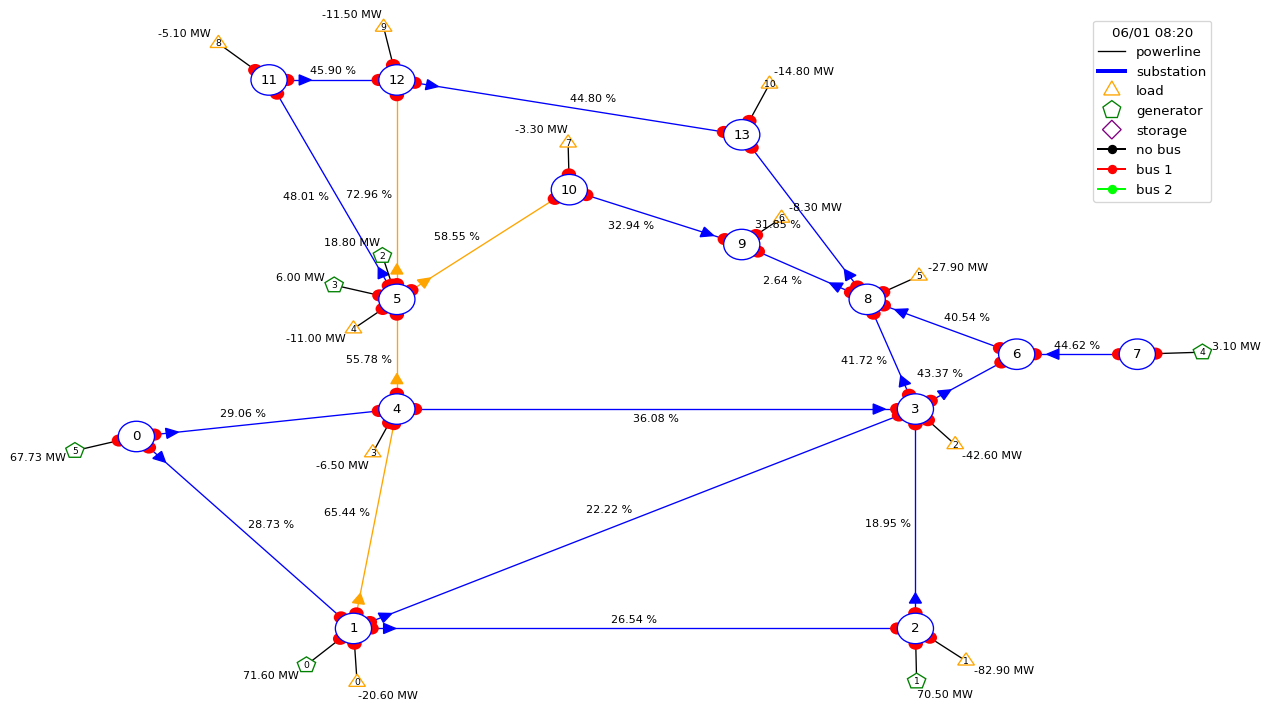

In [108]:
def train_dqn_agent():
    env = Gym2OpEnv(training=True) # Initialise env with seed

    model = DQN(policy=BoltzmannPolicy,
            env=env,
            learning_rate=1e-4,
            buffer_size=100000,
            learning_starts=1000,
            batch_size=32,
            tau=1.0,
            gamma=0.99,
            train_freq=4,
            gradient_steps=1,
            verbose=1,
            target_update_interval=1000,
            policy_kwargs={'temperature': 1.0},
        )
    
    model.learn(total_timesteps=10000)
    model.save("dqn_boltzmann_agent")

    # Evaluate the trained model
    obs, _ = env.reset()
    for step in range(100):
        action, _states = model.predict(obs)
        obs, reward, done, truncated, info = env.step(action)
        env.render()
        if done:
            print("Episode finished after {} timesteps".format(step + 1))
            break

if __name__ == "__main__":
    train_dqn_agent()

- #### `Evaluate` the environment

In [109]:
def evaluate_agent(model, env, num_episodes=10, seed=42):
    episode_rewards = []
    reward_sum = 0
    for episode in range(num_episodes):
        obs, _ = env.reset(seed=None)
        done = False
        total_reward = 0
        while not done:
            action, _states = model.predict(obs, deterministic=True)
            obs, reward, done, _, info = env.step(action)
            total_reward += reward
        episode_rewards.append(total_reward)
        print(f"Episode {episode + 1}: Total Reward = {total_reward}")
        reward_sum += total_reward
    print(f"Average Reward:", reward_sum/num_episodes)
    return episode_rewards

- #### `Run` the evaluation function

In [110]:
if __name__ == "__main__":
    # Initialize the environment and model
    eval_env = Gym2OpEnv(training=False)

    model = DQN(policy=BoltzmannPolicy,
            env=eval_env,
            learning_rate=1e-4,
            buffer_size=100000,
            learning_starts=1000,
            batch_size=32,
            tau=1.0,
            gamma=0.99,
            train_freq=4,
            gradient_steps=1,
            verbose=1,
            target_update_interval=1000,
            policy_kwargs={'temperature': 1.0},
        )
    
    # # Train the model
    # #model.learn(total_timesteps=10000)
    # #model.save("dqn_grid2op_agent")
    
    # Load the trained model
    model = DQN.load("dqn_grid2op_agent", env=eval_env)
    
    # Evaluate the trained model
    num_evaluation_episodes = 20
    rewards = evaluate_agent(model, eval_env, num_episodes=num_evaluation_episodes)

Available actions:
action 0: OrderedDict([('change_bus', array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])), ('change_line_status', array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False])), ('curtail', array([-1., -1., -1., -1., -1., -1.], dtype=float32)), ('redispatch', array([0., 0., 0., 0., 0., 0.], dtype=float32)), ('set_bus', array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 

- #### `Visualise` the results



In [113]:
def plot_rewards(episode_rewards):
    plt.figure(figsize=(12, 6))
    plt.plot(range(1, len(episode_rewards) + 1), episode_rewards, marker='o')
    plt.title('Agent Performance Over Episodes')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.grid(True)
    plt.show()


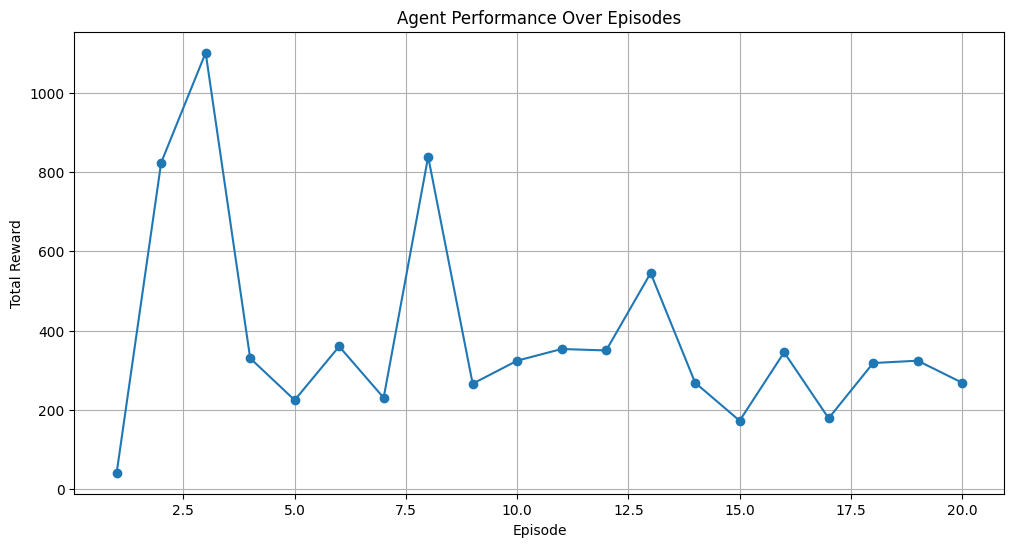

In [114]:
# call plot function
plot_rewards(rewards)